### Setup

In the setup, we will import the necessary libraries and define the queries that we will use to retrieve the documents from the Solr instance. With the queries, we will also define the corresponding relevance judgements.

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd

In [6]:
QRELS_FILE = "../datasets/information-systems-qrels.txt"
QUERY_URL = "http://localhost:8983/solr/universities/select?indent=true&q.op=OR&q=*%3A*&useParams=&wt=json"

# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(QRELS_FILE).readlines()))

print(relevant)

# Get query results from Solr instance

try:
  results = requests.get(QUERY_URL).json()['response']['docs']
except Exception as ex:
  print("Request failed: ", ex)

['Prague', 'Porto', 'University of Zagreb', 'United Kingdom']


### Getting the Metrics table

In this part, we calculate some common evaluation metrics that can be used to compare systems. We will calculate the Average Precision and Precision at 10 (P@10) metrics. The Average Precision is calculated as the average of the precision values at each relevant document; And, the P@10 is calculated as the proportion of relevant documents in the top 10 results.

In [7]:
# Define which attributes to check
attributes_to_check = ["wikipedia_text", "city_wikipedia_text"]

# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

# Average precision
@metric
def ap(results, relevant):
    precision_values = []
    relevant_count = 0

    for idx, doc in enumerate(results):
        for attribute in attributes_to_check:
            if doc[attribute] in relevant:
                relevant_count += 1
                precision_at_k = relevant_count / (idx + 1)
                precision_values.append(precision_at_k)
    if not precision_values:
        return 0.0

    return sum(precision_values)/len(precision_values)

# Precision at 10 (It is at N, but we defined n=10)
@metric
def p10(results, relevant, n=10):
    return len([doc for doc in results[:n] if doc['id'] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric','Value']] +
    [
        [evaluation_metrics[m], calculate_metric(m, results, relevant)] for m in evaluation_metrics
    ]
)

with open('results.tex','w') as tf:
    tf.write(df.to_latex())

[{'2024_rank': '2', '2023_rank': '2', 'institution_name_-_wrong': 'University of Cambridge', 'institution_name': 'University of Cambridge', 'country_code': 'UK', 'country': 'United Kingdom', 'size': 'L', 'focus': 'FC', 'age': '5.0', 'status': 'A', 'academic_reputation_score': '100', 'academic_reputation_rank': '3', 'employer_reputation_score': '100', 'employer_reputation_rank': '4.0', 'faculty_student_score': '100', 'faculty_student_rank': '14.0', 'citations_per_faculty_score': '92.3', 'citations_per_faculty_rank': '68.0', 'international_students_score': '95.8', 'international_students_rank': '85.0', 'international_research_network_score': '99.9', 'international_research_network_rank': '7.0', 'employment_outcomes_score': '100', 'employment_outcomes_rank': '6.0', 'overall_score': '99.2', 'wikidata': '{"entities": {"Q35794": {"type": "item", "id": "Q35794", "descriptions": {"en": {"language": "en", "value": "collegiate public research university in Cambridge, England, United Kingdom"}}}}

### Getting the Precision-Recall Curve

To finish the evaluation, we calculate a precision-recall curve, to provide a more visual clue about the systems' performance. The precision-recall curve is calculated using the precision and recall values as we move down the ranked list of documents. The precision is calculated as the proportion of relevant documents in the top N results; And, the recall is calculated as the proportion of relevant documents in the whole set of relevant documents.

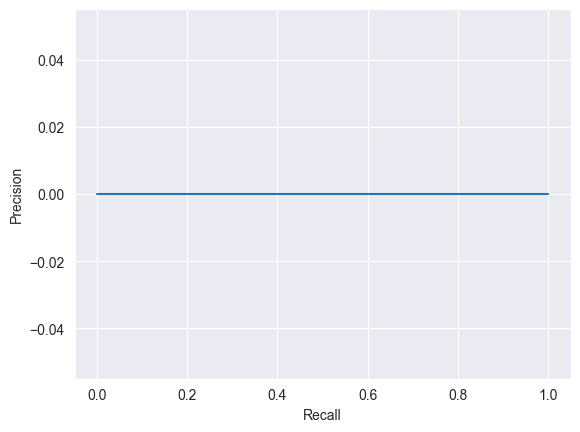

In [8]:
# Calculate precision and recall values as we move down the ranked list
precision_values = [
    len([
        doc 
        for doc in results[:idx]
        if doc['id'] in relevant
    ]) / idx 
    for idx, _ in enumerate(results, start=1)
]

recall_values = [
    len([
        doc for doc in results[:idx]
        if doc['id'] in relevant
    ]) / len(relevant)
    for idx, _ in enumerate(results, start=1)
]

precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}

# Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
recall_values = sorted(set(recall_values))

# Extend matching dict to include these new intermediate steps
for idx, step in enumerate(recall_values):
    if step not in precision_recall_match:
        if recall_values[idx-1] in precision_recall_match:
            precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
        else:
            precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
disp.plot()
plt.savefig('precision_recall.pdf')